## SwiGLU

GPT 使用 GELU 作为激活函数。 SwiGLU 是由 Transfomer 作者 Noam Shazzer 提出的。

SwiGLU 是由 **Swi**sh 激活函数和 **GLU**(Gated Linear Unit)结合的一种 FFN 特征学习器。

$$
\begin{align}
h &= \texttt{Swish}(\alpha w_1(x))\oplus(v(x))\\
y &= w_2(h)
\end{align}
$$

其中包含3个参数 $w_1, v, w_2$, 超参数 $\alpha = 1$, $\oplus$ 为逐元素乘

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
torch.manual_seed(42)

In [2]:
def swish(x, alpha=1.0):
    return x * torch.sigmoid(alpha * x)

class SwiGLU(nn.Module):
    def __init__(self, d):
        super().__init__()
        h = (8 * d // 3)
        self.w1 = nn.Linear(d, h)
        self.w_gate = nn.Linear(d, h)
        self.w2 = nn.Linear(h, d)
    def forward(self, x):
        gate = swish(self.w_gate(x)) # 特征门控
        x_up = self.w1(x) # 特征
        h = gate * x_up # SwiGLU 特征
        return self.w2(h)

model = SwiGLU(d = 512)
x = torch.randn(2, 3, 512)
print(model)
print(model(x).shape)

SwiGLU(
  (w1): Linear(in_features=512, out_features=1365, bias=True)
  (w_gate): Linear(in_features=512, out_features=1365, bias=True)
  (w2): Linear(in_features=1365, out_features=512, bias=True)
)
torch.Size([2, 3, 512])


代码实现简单，为什么用 SwiGLU 来代替 FFN，接下来 Step-by-Step 从实现到分析。

## Basic FFN

In [3]:
class FFN(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.w1 = nn.Linear(d, 4*d)
        self.w2 = nn.Linear(4*d, d)
        self.act = nn.ReLU()
    def forward(self, x):
        h = self.act(self.w1(x)) 
        return self.w2(h)

model = FFN(d = 4)
x = torch.randn(2, 3, 4)
print(model(x).shape)

torch.Size([2, 3, 4])


## Swish 激活函数

Swish 激活函数为 $f(x) = x \sigma(\alpha x)$, $\sigma(x)$ 是 sigmoid 函数, 可以将数据映射到 $(0,1)$ 范围。$\alpha$ 为常数


In [1]:
import matplotlib.pyplot as plt

def sigmoid(x):
    return  1.0 / (1 + torch.exp(torch.tensor([1])) ** (-x))


x = torch.arange(-100, 100) / 10.0
x_sigmoid = sigmoid(x)
x_swish = x*sigmoid(x)



plt.figure(figsize=(10, 4))
plt.plot(x.tolist(), x.tolist(), 'g', linewidth=2, label='y=x')
plt.plot(x.tolist(), x_sigmoid.tolist(), 'b', linewidth=2, label='y=sigmoid(x)')
plt.plot(x.tolist(), x_swish.tolist(), 'r', linewidth=2, label='y=x*sigmoid(x), swish')


plt.xlim(-6, 6)
plt.ylim(-1, 6)

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

NameError: name 'torch' is not defined

Swish 函数图像可以被看作是 ReLU 的平滑版本， 回顾 GELU 有同样的思想。 另外两者通用的形式为:

$$
\mathcal{F} = x \phi(x)
$$

当 $ \phi(x) \rightarrow -\infty = 0, \phi(x) \rightarrow +\infty = 1$, 同理 ReLU 可以同种形式表示：

$$
\phi_\text{ReLU}(x) = 
\begin{cases}
0, & \text{if } x < 0 \\
1, & \text{if } x \geq 0
\end{cases}
$$

ReLU 可以形式化为 $\texttt{ReLU}(x) = x \phi_\text{ReLU}(x)$

In [5]:
def swish(x, alpha = 1.0):
    return x * torch.sigmoid( alpha * x)

def gelu(x):
    # 近似版本
    cdf = 0.5 * (1.0 + torch.tanh( math.sqrt(2.0 / torch.pi) * (x + 0.044715 * torch.pow(x, 3))))
    return x * cdf
    
def relu(x):
    return (x + x.abs()) * 0.5

x = torch.arange(-100, 100) / 10.0
x_swish, x_gelu, x_relu,= swish(x), gelu(x), relu(x), #swish(x, alpha = 1.702)

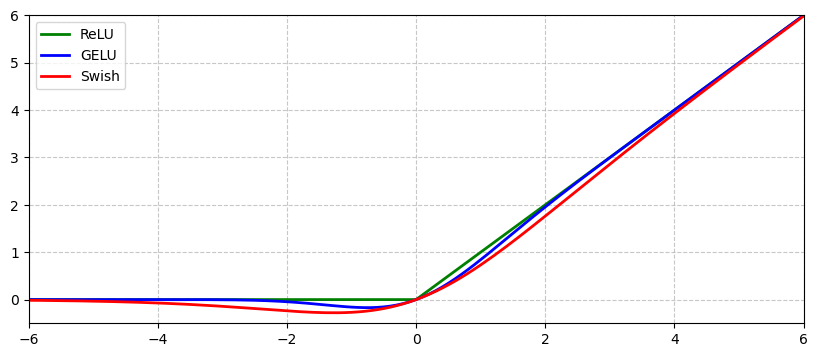

In [6]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 4))
plt.plot(x.tolist(), x_relu.tolist(), 'g', linewidth=2, label='ReLU')
plt.plot(x.tolist(), x_gelu.tolist(), 'b', linewidth=2, label='GELU')
plt.plot(x.tolist(), x_swish.tolist(), 'r', linewidth=2, label='Swish')
# plt.plot(x.tolist(), x_swish_alpha.tolist(), 'pink', linewidth=2, label='Swish-1.702') 

plt.xlim(-6, 6)
plt.ylim(-0.5, 6)

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

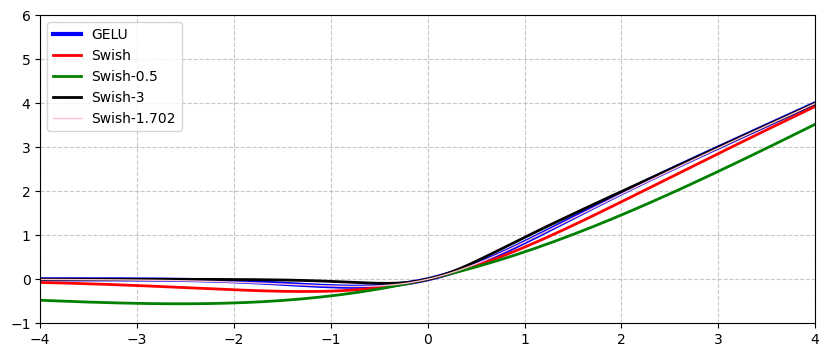

In [7]:
plt.figure(figsize=(10, 4))

x_1dot702 = swish(x, alpha = 1.702)
x_0dot5 = swish(x, alpha = 0.5)
x_3 = swish(x, alpha = 3)

# plt.plot(x.tolist(), x_relu.tolist(), 'g', linewidth=2, label='ReLU')
plt.plot(x.tolist(), x_gelu.tolist(), 'b-', linewidth=3, label='GELU')
plt.plot(x.tolist(), x_swish.tolist(), 'r', linewidth=2, label='Swish')
plt.plot(x.tolist(), x_0dot5.tolist(), 'g', linewidth=2, label='Swish-0.5') 
plt.plot(x.tolist(), x_3.tolist(), 'black', linewidth=2, label='Swish-3') 
plt.plot(x.tolist(), x_1dot702.tolist(), 'pink', linewidth=1, label='Swish-1.702') 

# plt.xlim(-6, 6)
# plt.ylim(-1, 6)
plt.xlim(-4, 4)
plt.ylim(-1, 6)

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## Swish 激活函数小结：

1. Swish 激活函数是 ReLU 平滑版本，相较 GELU 计算简单，由于 sigmoid 特性求导简单。
2. Swish 设置 alpha 参数：（1） alpha=1 标准 swish （2）alpha=1.702 近似 GELU （3）alpha < 1 平滑程度越大 （4） alpha > 1 平滑程度越小

思考 alpha 趋近正无穷，是否逼近 RELU？

对于 alpha 参数放大，本质上使得 sigmoid 两端快速进入到收敛状态

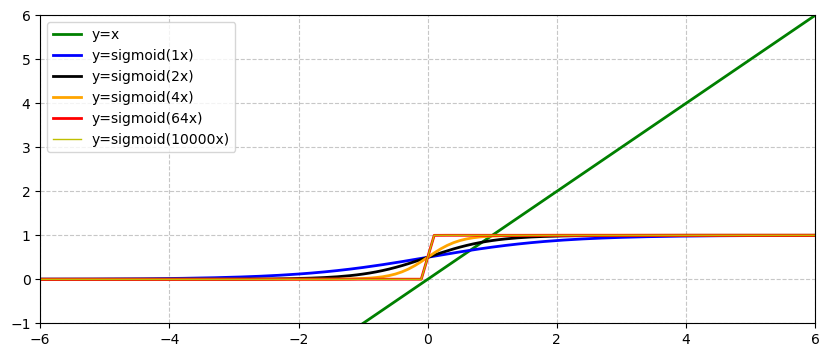

In [8]:
def sigmoid(x, alpha = 1.0):
    return  1.0 / (1 + torch.exp(torch.tensor([1])) ** (- alpha * x))

x = torch.arange(-100, 100) / 10.0
x_sigmoid = sigmoid(x, alpha = 1.0)
x_sigmoid_2 = sigmoid(x, alpha = 2.0)
x_sigmoid_4 = sigmoid(x, alpha = 4.0)
x_sigmoid_64 = sigmoid(x, alpha = 64.0)
x_sigmoid_1w = sigmoid(x, alpha = 10000.0)

plt.figure(figsize=(10, 4))
plt.plot(x.tolist(), x.tolist(), 'g', linewidth=2, label='y=x')
plt.plot(x.tolist(), x_sigmoid.tolist(), 'b', linewidth=2, label='y=sigmoid(1x)')
plt.plot(x.tolist(), x_sigmoid_2.tolist(), 'k', linewidth=2, label='y=sigmoid(2x)')
plt.plot(x.tolist(), x_sigmoid_4.tolist(), 'orange', linewidth=2, label='y=sigmoid(4x)')
plt.plot(x.tolist(), x_sigmoid_64.tolist(), 'r', linewidth=2, label='y=sigmoid(64x)')
plt.plot(x.tolist(), x_sigmoid_1w.tolist(), 'y', linewidth=1, label='y=sigmoid(10000x)') # 与 64 重合


plt.xlim(-6, 6)
plt.ylim(-1, 6)

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## Gated Linear Unit

线形门控单元是一种特征选择机制。 对于高维特征，需要细粒度筛选哪个维度更加重要.

对于 LLM 中， 数据维度为 `[bsz, seq_len, dim]` , 这里的特征需要筛选指 `dim`, 需要区分机制：

1. 特征变换：形如 x@w，w 为变换矩阵，从一个特征空间变换到另一个特征空间
2. 特征选择：形如 x*w, w 为 dim 维的权重向量, 当 w 为 二值向量{0,1} 元素组成，则为硬选择（稀疏选择），当 w 为浮点向量是，则为软选择

想象一个酒吧，有一排啤酒水龙头，定义越多人喝的啤酒则价格越高，那么这一排水龙头价格向量 则可以为权重向量。

In [9]:
def GLU(x):
    gate = torch.sin(x)
    y = gate * x
    return y

x = torch.randn(1, 8) 
y_sin = GLU(x)

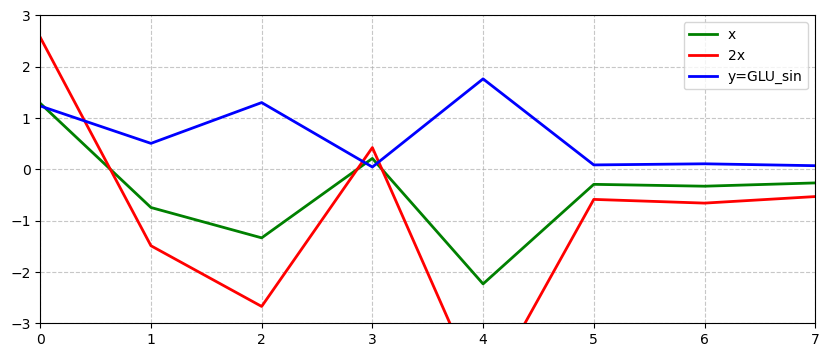

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(torch.arange(8).tolist(), x[0,:].tolist(), 'g', linewidth=2, label='x')
plt.plot(torch.arange(8).tolist(), (2*x[0,:]).tolist(), 'r', linewidth=2, label='2x')
plt.plot(torch.arange(8).tolist(), y_sin[0,:].tolist(), 'b', linewidth=2, label='y=GLU_sin')
plt.xlim(0, 7)
plt.ylim(-3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

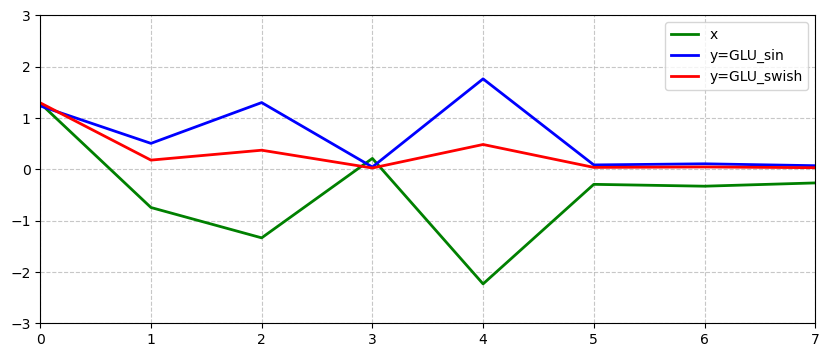

In [11]:
def GLU_swish(x):
    gate = swish(x)
    y = gate * x
    return y

y_glu_swish = GLU_swish(x)

plt.figure(figsize=(10, 4))
plt.plot(torch.arange(8).tolist(), x[0,:].tolist(), 'g', linewidth=2, label='x')
plt.plot(torch.arange(8).tolist(), y_sin[0,:].tolist(), 'b', linewidth=2, label='y=GLU_sin')
plt.plot(torch.arange(8).tolist(), y_glu_swish[0,:].tolist(), 'r', linewidth=2, label='y=GLU_swish')
plt.xlim(0, 7)
plt.ylim(-3, 3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## FFN-GLU

引入门控机制，相较原版的 FFN， 则在特征维度上，增加细粒度的筛选。

In [12]:
class FFNWithBasicGLU(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.w1 = nn.Linear(d, d) # 输入输出维度相等
        self.w2 = nn.Linear(d, d)
        self.act = nn.ReLU()
    def forward(self, x):
        # h = self.act(self.w1(x))
        h = self.act(x) * self.w1(x) # 门控无学习参数
        return self.w2(h)

model = FFNWithBasicGLU(d = 4)
x = torch.randn(2, 3, 4)
print(model(x).shape)

torch.Size([2, 3, 4])


In [13]:
class FFNWithGLU(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.w1 = nn.Linear(d, 4*d) # 标准 FFN
        self.w2 = nn.Linear(4*d, d)
        self.act = nn.ReLU()
    def forward(self, x):
        # h = self.act(self.w1(x))
        # h = self.act(x) * self.w1(x) # 错误, 特征维度不等
        h = self.act(self.w1(x)) * self.w1(x) # 左项学习式门控
        return self.w2(h)

model = FFNWithGLU(d = 4)
x = torch.randn(2, 3, 4)
print(model(x).shape)

torch.Size([2, 3, 4])


In [14]:
class FFNWithSwishGLU(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.w1 = nn.Linear(d, 4*d)
        self.w2 = nn.Linear(4*d, d)
    def forward(self, x):
        # h = self.act(self.w1(x))
        h = swish(self.w1(x)) * self.w1(x) # swish 激活函数
        return self.w2(h)

model = FFNWithSwishGLU(d = 4)
x = torch.randn(2, 3, 4)
print(model(x).shape)

torch.Size([2, 3, 4])


## SwiGLU

1. GLU 章节中，描述了 sin 门控和 swish 门控，其门控规则是“函数级别”映射
2. FFN-GLU 章节中，在 FFN 基础上引入了 GLU 机制，这个机制是“学习式”的，即swish(w1(x)), w1 是可学习参数

在 2 中，`swish(self.w1(x)) * self.w1(x)`， 可以认为 w1 同时做 “门控学习” 和 “特征学习”

将门控学习由独立的参数 $w_gate$ 进行变换，`self.w_gate(x)` 运算得到 “门控特征”

In [15]:
class SwiGLU(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.w1 = nn.Linear(d, 4*d)
        self.w_gate = nn.Linear(d, 4*d)
        self.w2 = nn.Linear(4*d, d)
    def forward(self, x):
        gate = swish(self.w_gate(x)) # 特征门控
        x_up = self.w1(x) # 特征
        h = gate * x_up # SwiGLU 特征
        return self.w2(h)

model = SwiGLU(d = 4)
x = torch.randn(2, 3, 4)
print(model(x).shape)

torch.Size([2, 3, 4])


In [16]:
print(model.w1(x).shape)
gate = swish(model.w_gate(x)) # 特征门控
print(gate.shape)
print(gate[0,0, :])
print(gate[0,1, :])

torch.Size([2, 3, 16])
torch.Size([2, 3, 16])
tensor([ 0.1850,  0.4123, -0.1568,  0.1320, -0.0810, -0.0348,  0.4191, -0.2175,
         0.4638,  0.0620,  0.7025, -0.2769,  0.0374,  0.5542,  0.3451, -0.1782],
       grad_fn=<SliceBackward0>)
tensor([-1.9604e-01, -1.3069e-01, -2.5348e-01, -1.8677e-01,  1.5550e-01,
        -7.5397e-02, -1.4446e-02,  9.1672e-02,  2.1247e-02, -1.4432e-01,
        -8.7969e-02, -1.4882e-01, -2.0233e-01, -5.3613e-02,  5.0739e-01,
         4.3106e-04], grad_fn=<SliceBackward0>)


### SwiGLU 分析

1. FFN 是 token-wise 独立的特征学习模型， token 之间不做交互
2. SwiGLU 同样是 token-wise 的特征学习模型， gate 是 “因材施教”， 不同的 token feature 有独立的门控
3. 门控是可以被学习的，这是多出一个参数 `w_gate` 的意义
4. 门控学习本质是特征选择，思考 LayerNorm 与 GLU 的特征选择机制的区别？

在上述实现中，多了 `w_gate` 参数多了 50%, 考虑 FFN 与 SwiGLU 同等参数量，输入输出维度为$d$, 定义 SwiGLU hidden_dim 为 d ，有以下等式：

$$
\begin{align}
3(d \cdot h) &= 2(d \cdot 4d)  \\
3h &= 8d  \\
h &= \frac{8}{3}d  \\
\end{align}
$$

In [17]:
class SwiGLU(nn.Module):
    def __init__(self, d):
        super().__init__()
        h = (8 * d // 3)
        self.w1 = nn.Linear(d, h)
        self.w_gate = nn.Linear(d, h)
        self.w2 = nn.Linear(h, d)
    def forward(self, x):
        gate = swish(self.w_gate(x)) # 特征门控
        x_up = self.w1(x) # 特征
        h = gate * x_up # SwiGLU 特征
        return self.w2(h)

model = SwiGLU(d = 512)
x = torch.randn(2, 3, 512)
print(model)
print(model(x).shape)

SwiGLU(
  (w1): Linear(in_features=512, out_features=1365, bias=True)
  (w_gate): Linear(in_features=512, out_features=1365, bias=True)
  (w2): Linear(in_features=1365, out_features=512, bias=True)
)
torch.Size([2, 3, 512])


## 总结

1. Swish 激活函数是神之函数
2. SwiGLU 在 FFN 增加一个特征选择机制，特征选择是 token-feature aware 的
3. SwiGLU 通过实验证明性能，但原 paper 并未探究 SwiGLU 有效的原因
4. 思考: 增加一种新的特征学习机制？来提升模型特征学习能力
5. LLM 模型结构发展趋势是： 降低 attention 时空复杂度（GQA、Sparse、Linear、MLA)，提升 FFN 学习容量（增加hidden维度，sMoE）